In [1]:
%matplotlib inline

import os
import warnings
import collections
import time
from datetime import timedelta
import ta

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # This error most likely means that this notebook is not 
    # configured to use a GPU.  Change this in Notebook Settings via the 
    # command palette (cmd/ctrl-shift-P) or the Edit menu.
    device_name = '/device:CPU:0'

print( 'tf version :', tf.__version__ )
print( 'tfp version:', tfp.__version__ )
print( 'devide name:', device_name )



tf version : 2.1.0
tfp version: 0.9.0
devide name: /device:GPU:0


In [2]:
dataset_headers = ['date-time','O','H','L','C','V']
dataset_dtype = 'float32'
dataset_dtypes = {'O':dataset_dtype,'H':dataset_dtype,'L':dataset_dtype,'C':dataset_dtype,'C':dataset_dtype}
dataset_file = '../../../lambda-asset-corpus/ALL/XAUUSD_1M_ALL.csv'
dataset_sep = ';'

dataset = pd.read_csv( dataset_file, sep=dataset_sep, names=dataset_headers, dtype=dataset_dtypes )
print( dataset['date-time'][0] )
dataset['date-time'] =  pd.to_datetime( dataset['date-time'], format='%Y%m%d %H%M%S')
print( dataset['date-time'][0] )

dataset = dataset.set_index( ['date-time'] )
dataset.tail( 5 )



20090315 170000
2009-03-15 17:00:00


,O,H,L,C,V
date-time,,,,,
2018-12-31 16:54:00,1282.484985,1282.484985,1282.425049,1282.432983,0
2018-12-31 16:55:00,1282.420044,1282.598022,1282.420044,1282.598022,0
2018-12-31 16:56:00,1282.598022,1282.647949,1282.454956,1282.505005,0
2018-12-31 16:57:00,1282.494995,1282.547974,1282.447998,1282.547974,0
2018-12-31 16:58:00,1282.447998,1282.535034,1282.305054,1282.305054,0


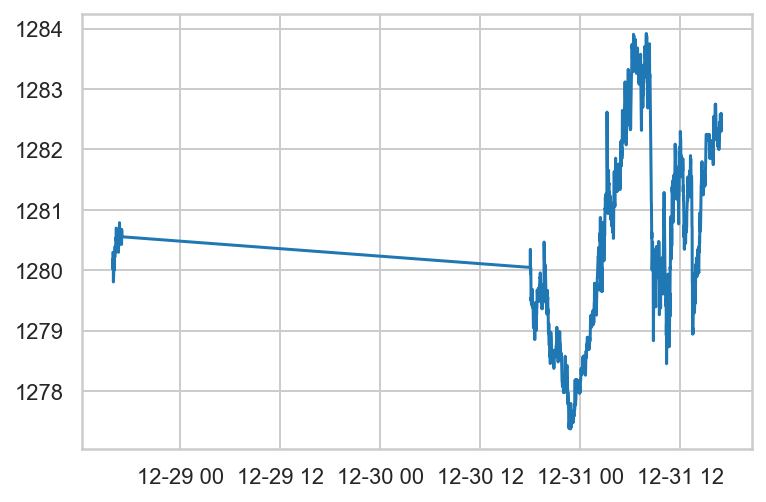

In [3]:
close = dataset['C'][-1440:]
plt.plot(close)

In [4]:
close[:-1].head()


date-time
2018-12-28 15:54:00    1280.297974
2018-12-28 15:55:00    1280.017944
2018-12-28 15:56:00    1280.098022
2018-12-28 15:57:00    1280.197998
2018-12-28 15:58:00    1279.807983
Name: C, dtype: float32

In [5]:
close[1:].head()

date-time
2018-12-28 15:55:00    1280.017944
2018-12-28 15:56:00    1280.098022
2018-12-28 15:57:00    1280.197998
2018-12-28 15:58:00    1279.807983
2018-12-28 15:59:00    1279.897949
Name: C, dtype: float32

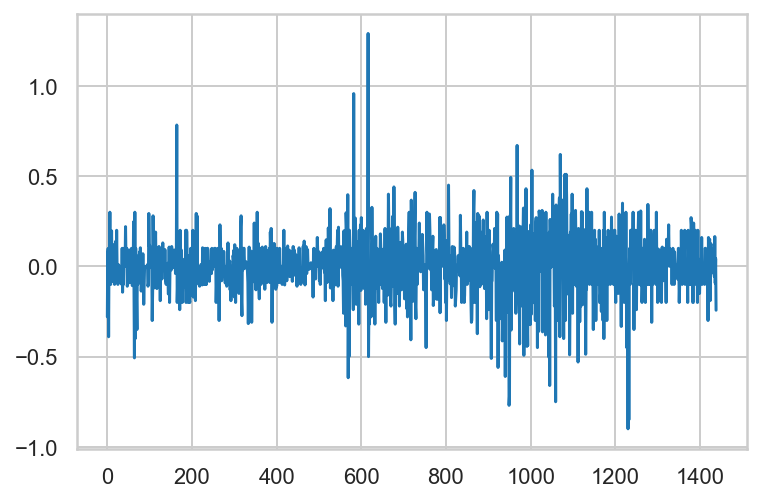

In [6]:
diff = np.diff( close, n=1 )
plt.plot( diff )
plt.show()

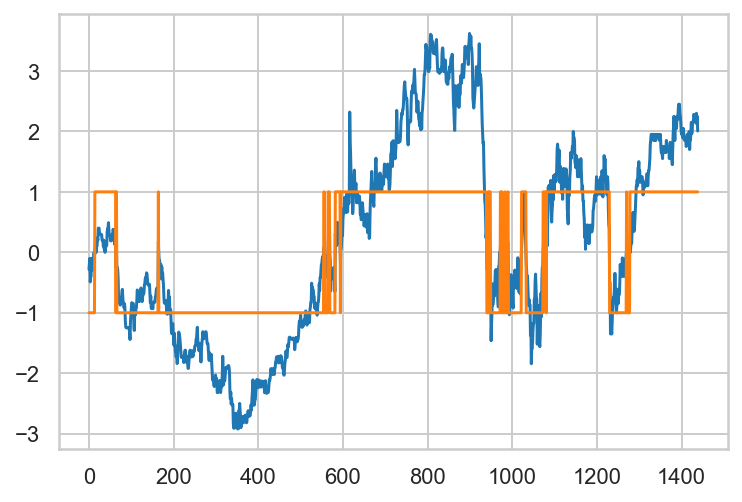

In [7]:
pos = [ (x>0) * x for x in diff ]
neg = [ (x<0) * x for x in diff ]

cumsum = np.cumsum( diff )
poscum = np.cumsum( pos ) 
negcum = np.cumsum( neg )
negcum = negcum * -1.0

def f( x ):
    global last
    global direction
    if x > 0 and x > last:
        last = x
        direction = 1
    if x < 0 and x < last:
        last = x
        direction = -1
    return direction

last = 0
direction = 0
signal = [ f(x) for x in cumsum ]

#plt.plot( negcum )
#plt.plot( poscum )
plt.plot( cumsum )
plt.plot( signal )
plt.show()

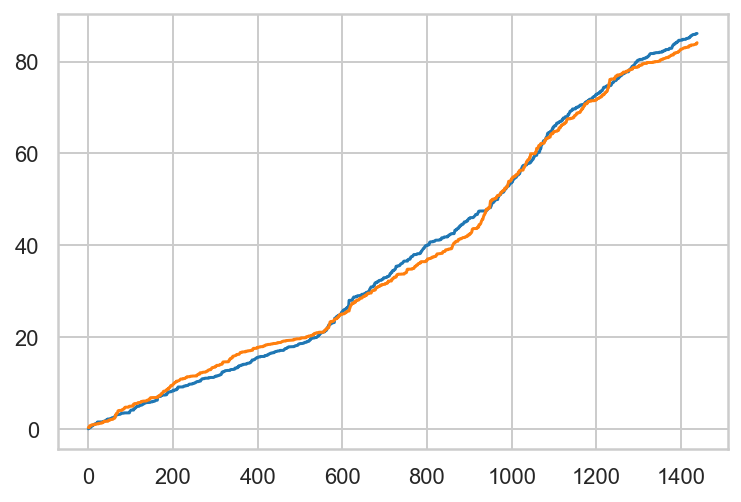

In [8]:
plt.plot( poscum )
plt.plot( negcum )
plt.show()

In [48]:
def zigzag(s, pct=0.04):
    
    ut = 1 + pct
    dt = 1 - pct

    ld = s.index[0]
    lp = s.C[ld]
    tr = None

    zzd, zzp, zzt = [ld], [lp], [0]

    for ix, ch, cl in zip(s.index, s.H, s.L):
        # No initial trend
        if tr is None:
            if ch / lp > ut:
                tr = 1
            elif cl / lp < dt:
                tr = -1
        # Trend is up
        elif tr == 1:
            # New H
            if ch > lp:
                ld, lp = ix, ch
            # Reversal
            elif cl / lp < dt:
                zzd.append(ld)
                zzp.append(lp)
                zzt.append(tr)

                tr, ld, lp = -1, ix, cl
        # Trend is down
        else:
            # New L
            if cl < lp:
                ld, lp = ix, cl
            # Reversal
            elif ch / lp > ut:
                zzd.append(ld)
                zzp.append(lp)
                zzt.append(tr)

                tr, ld, lp = 1, ix, ch

    # Extrapolate the current trend
    if zzd[-1] != s.index[-1]:
        zzd.append(s.index[-1])

        if tr is None:
            zzp.append(s.C[zzd[-1]])
            zzt.append(0)
        elif tr == 1:
            zzp.append(s.H[zzd[-1]])
            zzt.append(1)
        else:
            zzp.append(s.L[zzd[-1]])
            zzt.append(-1)
    df = pd.DataFrame( index=zzd, columns=['ZZ','ZT'] )
    df['ZZ'] = zzp
    df['ZT'] = zzt
    return df

In [45]:
zz = zigzag( dataset, pct=0.04 )


In [47]:
zzdiff = np.diff( zz['ZZ'], n=1 )
zzdiffabs = np.abs( zzdiff )
print( 'length', len( zz ) )
print( 'sum', zzdiffabs.sum() )


length 159
sum 17282.67529296875


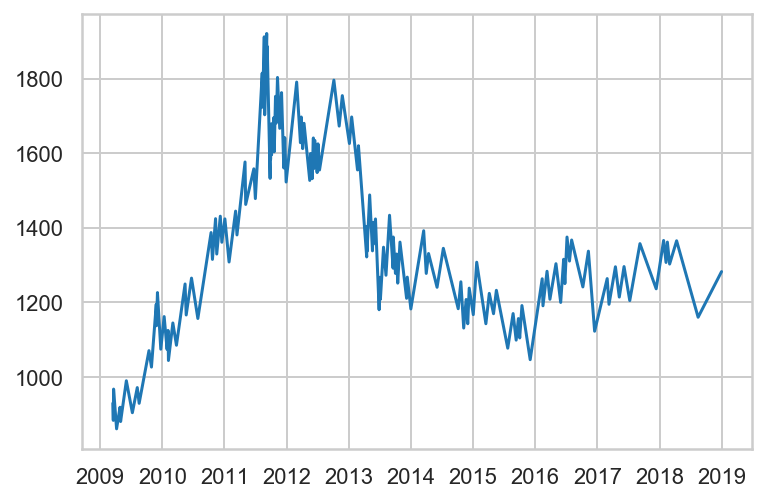

In [51]:
plt.plot(zz['ZZ'])
plt.show()

In [52]:
zz.head()


,ZZ,ZT
2009-03-15 17:00:00,929.599976,0
2009-03-18 11:36:00,883.650024,-1
2009-03-20 04:02:00,967.549988,1
2009-04-06 18:00:00,861.000000,-1
2009-04-26 20:34:00,918.880005,1


In [55]:
dz = pd.concat( [dataset, zz], axis=1, sort=False )
dz.head()

,O,H,L,C,V,ZZ,ZT
2009-03-15 17:00:00,929.599976,929.599976,929.599976,929.599976,0,929.599976,0.0
2009-03-15 18:00:00,925.849976,927.000000,925.799988,926.049988,0,NaN,NaN
2009-03-15 18:01:00,925.799988,927.299988,925.799988,925.900024,0,NaN,NaN
2009-03-15 18:02:00,925.900024,926.450012,925.900024,925.900024,0,NaN,NaN
2009-03-15 18:03:00,925.849976,926.950012,925.849976,926.950012,0,NaN,NaN
